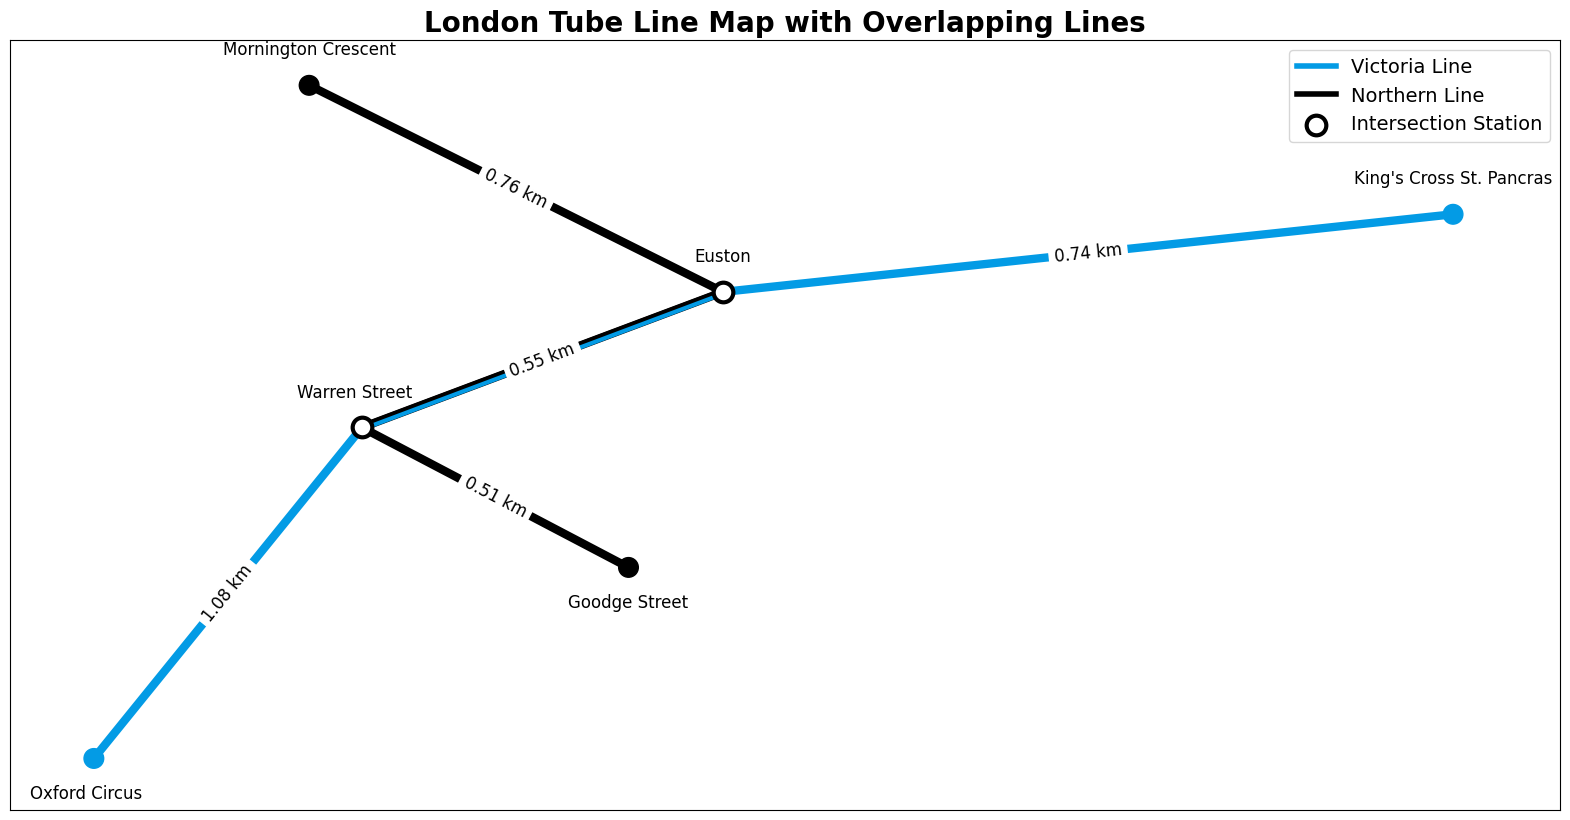

In [19]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------- Data Loading -------------------
file_path = 'London stations.csv'  # Replace with the actual file path
stations_data = pd.read_csv(file_path)
stations_data.columns = stations_data.columns.str.strip()  # Remove extra spaces

# ------------------- Haversine Function -------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Graph Data Preparation -------------------
victoria_line_edges = [
    ("Oxford Circus", "Warren Street"),
    ("Warren Street", "Euston"),
    ("Euston", "King's Cross St. Pancras")
]

northern_line_edges = [
    ("Goodge Street", "Warren Street"),
    ("Warren Street", "Euston"),
    ("Euston", "Mornington Crescent"),
]

edges = []
edge_labels = {}
color_mapping = {
    'victoria': '#039BE5',
    'northern': '#000000'
}

for edge_list, line_color in [(victoria_line_edges, color_mapping['victoria']),
                              (northern_line_edges, color_mapping['northern'])]:
    for edge in edge_list:
        station1 = stations_data[stations_data['Station'] == edge[0]].iloc[0]
        station2 = stations_data[stations_data['Station'] == edge[1]].iloc[0]
        distance = haversine(station1['Latitude'], station1['Longitude'],
                             station2['Latitude'], station2['Longitude'])
        edges.append((edge[0], edge[1], round(distance, 2), line_color))
        edge_labels[(edge[0], edge[1])] = f"{round(distance, 2)} km"

G = nx.Graph()
for _, row in stations_data.iterrows():
    G.add_node(row['Station'], pos=(row['Longitude'], row['Latitude']))

for edge in edges:
    G.add_edge(edge[0], edge[1], color=edge[3], weight=edge[2])

stations_by_line = {
    'victoria': set(station for edge in victoria_line_edges for station in edge),
    'northern': set(station for edge in northern_line_edges for station in edge)
}

intersection_stations = set()
for station in G.nodes():
    line_count = sum(station in stations_by_line[line] for line in stations_by_line)
    if line_count >= 2:
        intersection_stations.add(station)

# ------------------- Filter and Assign Colors -------------------
node_colors = {}
for node in G.nodes():
    if node in stations_by_line['victoria']:
        node_colors[node] = color_mapping['victoria']
    elif node in stations_by_line['northern']:
        node_colors[node] = color_mapping['northern']
    elif node in intersection_stations:
        node_colors[node] = 'white'  # Highlight intersection nodes

# Filter the graph to include only relevant nodes
relevant_nodes = set(node_colors.keys())
G_filtered = G.subgraph(relevant_nodes)

# Define adjusted label positions for nodes
label_pos_adjustments = {
    "Oxford Circus": (-0.0001, -0.001),
    "Warren Street": (-0.0001, 0.001),
    "King's Cross St. Pancras": (0, 0.001),
    "Goodge Street": (0, -0.001),
    "Mornington Crescent": (0, 0.001),
    "Euston": (0, 0.001),
}

adjusted_positions = {}
for node, pos in nx.get_node_attributes(G_filtered, 'pos').items():
    adjustment = label_pos_adjustments.get(node, (0, 0))  # Default to no adjustment
    adjusted_positions[node] = (pos[0] + adjustment[0], pos[1] + adjustment[1])

# ------------------- Handling Overlapping Edges -------------------
def adjust_positions(pos, offset):
    """Adjust positions for overlapping edges."""
    return {k: (v[0] + offset[0], v[1] + offset[1]) for k, v in pos.items()}

overlapping_edges = {("Warren Street", "Euston"): ("northern", "victoria")}
offsets = {
    "northern": (-0.00003, 0.00003),  # Minimal positional shift
    "victoria": (0.00003, -0.00003)
}

# ------------------- Graph Visualization -------------------
plt.figure(figsize=(20, 10))
positions = nx.get_node_attributes(G_filtered, 'pos')

# Draw non-overlapping edges
for u, v in [e for e in G_filtered.edges if e not in overlapping_edges]:
    nx.draw_networkx_edges(
        G_filtered,
        pos=positions,
        edgelist=[(u, v)],
        edge_color=G_filtered[u][v]['color'],
        width=6
    )

# Draw overlapping edges
for (u, v), (line1, line2) in overlapping_edges.items():
    for line, offset in [(line1, offsets[line1]), (line2, offsets[line2])]:
        nx.draw_networkx_edges(
            G_filtered,
            pos=adjust_positions(positions, offset),
            edgelist=[(u, v)],
            edge_color=color_mapping[line],
            width=3
        )

# Draw nodes
nx.draw_networkx_nodes(
    G_filtered,
    pos=positions,
    node_color=[node_colors[node] for node in G_filtered.nodes()],
    node_size=200
)

# Draw intersection nodes
for node in intersection_stations:
    if node in G_filtered.nodes:
        x, y = positions[node]
        plt.scatter(x, y, s=200, color='white', edgecolor='black', linewidth=3, zorder=3)

# Draw labels
nx.draw_networkx_labels(
    G_filtered,
    pos=adjusted_positions,
    font_size=12,
    font_weight='normal'
)

# Draw edge labels
nx.draw_networkx_edge_labels(
    G_filtered,
    pos=positions,
    edge_labels=edge_labels,
    font_size=12
)

# Add legend
plt.plot([], [], color=color_mapping['victoria'], linewidth=4, label='Victoria Line')
plt.plot([], [], color=color_mapping['northern'], linewidth=4, label='Northern Line')
plt.scatter([], [], color='white', edgecolor='black', s=200, linewidth=3, label='Intersection Station')
plt.legend(loc='upper right', fontsize=14)

plt.title("London Tube Line Map with Overlapping Lines", fontsize=20, fontweight='bold')
plt.show()
